In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset, random_split
from torchvision import datasets, transforms
from skimage.transform import radon
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from torchvision import transforms
import torch.optim as optim

In [2]:
# UNet Model Classes
class DoubleConv(nn.Module):
    """
    A module consisting of two sequential convolutional layers,
    each followed by batch normalization and a ReLU activation.
    """
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super(DoubleConv, self).__init__()
        if not mid_channels:
            mid_channels = out_channels  # If mid_channels not specified, set it to out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),  # First convolution
            nn.BatchNorm2d(mid_channels),                                     # Batch normalization
            nn.ReLU(inplace=True),                                            # ReLU activation
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),  # Second convolution
            nn.BatchNorm2d(out_channels),                                     # Batch normalization
            nn.ReLU(inplace=True)                                             # ReLU activation
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """
    Downscaling with maxpool followed by DoubleConv.
    """
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),                 # Max pooling for downsampling
            DoubleConv(in_channels, out_channels)  # Double convolution
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """
    Upscaling followed by DoubleConv.
    Can use either bilinear interpolation or transposed convolutions.
    """
    def __init__(self, in_channels, out_channels, bilinear=True):
        super(Up, self).__init__()

        # If using bilinear interpolation
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            # Using transposed convolution for upsampling
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)
        
        # Double convolution after upsampling
        self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)

    def forward(self, x1, x2):
        x1 = self.up(x1)  # Upsample the input

        # Compute padding to match dimensions with the skip connection
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        # Pad x1 to match x2's dimensions
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        # Concatenate along the channels axis
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    """
    Final convolution layer to reduce the number of channels to the desired output.
    """
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)  # 1x1 convolution

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    """
    U-Net architecture for image segmentation or reconstruction.
    Consists of a contracting path and an expansive path with skip connections.
    """
    def __init__(self, n_channels=1, n_classes=1, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels     # Number of input channels
        self.n_classes = n_classes       # Number of output channels/classes
        self.bilinear = bilinear         # Use bilinear interpolation if True

        # Contracting path (encoder)
        self.inc = DoubleConv(n_channels, 64)   # Initial convolution
        self.down1 = Down(64, 128)              # Downsample 1
        self.down2 = Down(128, 256)             # Downsample 2
        self.down3 = Down(256, 512)             # Downsample 3
        self.down4 = Down(512, 512)             # Downsample 4

        # Expansive path (decoder)
        self.up1 = Up(1024, 256, bilinear)      # Upsample 1
        self.up2 = Up(512, 128, bilinear)       # Upsample 2
        self.up3 = Up(256, 64, bilinear)        # Upsample 3
        self.up4 = Up(128, 64, bilinear)        # Upsample 4

        # Output layer
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        # Encoder path
        x1 = self.inc(x)        # Input convolution
        x2 = self.down1(x1)     # Downsample 1
        x3 = self.down2(x2)     # Downsample 2
        x4 = self.down3(x3)     # Downsample 3
        x5 = self.down4(x4)     # Downsample 4

        # Decoder path with skip connections
        x = self.up1(x5, x4)    # Upsample 1
        x = self.up2(x, x3)     # Upsample 2
        x = self.up3(x, x2)     # Upsample 3
        x = self.up4(x, x1)     # Upsample 4

        logits = self.outc(x)   # Output convolution
        return torch.sigmoid(logits)  # Use sigmoid activation for binary outputs


In [3]:
def apply_radon_transform(image, theta=None):
    """
    Applies the Radon transform to a single image.

    Args:
        image (Tensor): Input image tensor of shape (1, H, W).
        theta (array): Angles at which to compute the Radon transform.

    Returns:
        Tensor: Radon-transformed image of shape (1, H, W).
    """
    if theta is None:
        # Generate default angles
        theta = np.linspace(0., 180., max(image.shape[-2], image.shape[-1]), endpoint=False)

    # Convert tensor to numpy array and remove channel dimension
    img_np = image.squeeze().cpu().numpy()  # Shape: (H, W)

    # Apply Radon transform
    radon_img = radon(img_np, theta=theta, circle=True)  # Shape: (H, len(theta))

    # Convert back to tensor and add channel dimension
    radon_img = torch.from_numpy(radon_img).float().unsqueeze(0)  # Shape: (1, H, W)
    return radon_img

class RadonDataset(Dataset):
    """
    Custom dataset that applies the Radon transform to MNIST images.

    Args:
        mnist_data (Dataset): MNIST dataset.
        theta (array): Angles at which to compute the Radon transform.
        transform (callable): Optional transform to be applied on a sample.
    """
    def __init__(self, mnist_data, theta=None, transform=None):
        self.mnist_data = mnist_data
        self.transform = transform
        self.theta = theta if theta is not None else np.linspace(0., 180., 256, endpoint=False)

    def __len__(self):
        return len(self.mnist_data)

    def __getitem__(self, idx):
        # Get image and ignore the label
        image, _ = self.mnist_data[idx]  # Shape: (1, H, W)

        # Apply Radon transform to the image
        radon_image = apply_radon_transform(image, self.theta)  # Shape: (1, H, W)

        if self.transform:
            # Apply transformations to both the original and Radon images
            image = self.transform(image)              # Shape: (1, H, W)
            radon_image = self.transform(radon_image)  # Shape: (1, H, W)

        return radon_image, image  # Return the Radon image and the original image

In [4]:
def plot_results(input_image, output_image, ground_truth, idx=0):
    """
    Plots the input Radon image, the reconstructed image, and the ground truth image.

    Args:
        input_image (Tensor): Batch of input images (Radon-transformed), shape: (batch_size, 1, H, W).
        output_image (Tensor): Batch of reconstructed images, shape: (batch_size, 1, H, W).
        ground_truth (Tensor): Batch of ground truth images, shape: (batch_size, 1, H, W).
        idx (int): Index of the image in the batch to plot.
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plot input Radon image
    axes[0].imshow(input_image[idx].cpu().squeeze(), cmap='gray')
    axes[0].set_title('Input (Radon)')
    axes[0].axis('off')

    # Plot reconstructed image
    axes[1].imshow(output_image[idx].cpu().detach().squeeze(), cmap='gray')
    axes[1].set_title('Reconstructed')
    axes[1].axis('off')

    # Plot ground truth image
    axes[2].imshow(ground_truth[idx].cpu().squeeze(), cmap='gray')
    axes[2].set_title('Ground Truth')
    axes[2].axis('off')

    plt.show()

In [5]:
def train(model, dataloader, optimizer, criterion, device):
    """
    Trains the model for one epoch.

    Args:
        model (nn.Module): The neural network model to train.
        dataloader (DataLoader): DataLoader for the training data.
        optimizer (Optimizer): Optimizer for updating the model parameters.
        criterion (Loss): Loss function to optimize.
        device (torch.device): Device to perform computations on.

    Returns:
        float: Average training loss over the epoch.
    """
    model.train()  # Set model to training mode
    running_loss = 0.0

    # Loop over batches
    for batch_idx, (inputs, targets) in enumerate(dataloader):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()           # Zero the parameter gradients
        outputs = model(inputs)         # Forward pass
        loss = criterion(outputs, targets)  # Compute loss
        loss.backward()                 # Backward pass
        optimizer.step()                # Update model parameters

        running_loss += loss.item() * inputs.size(0)  # Accumulate loss

        # Print progress every 100 batches
        if (batch_idx + 1) % 100 == 0 or (batch_idx + 1) == len(dataloader):
            print(f'Batch [{batch_idx + 1}/{len(dataloader)}], Loss: {loss.item():.4f}')

    average_loss = running_loss / len(dataloader.dataset)
    return average_loss

In [6]:
def test(model, dataloader, criterion, device):
    """
    Evaluates the model on the validation or test dataset.

    Args:
        model (nn.Module): The neural network model to evaluate.
        dataloader (DataLoader): DataLoader for the validation/test data.
        criterion (Loss): Loss function to evaluate.
        device (torch.device): Device to perform computations on.

    Returns:
        float: Average validation/test loss.
    """
    model.eval()  # Set model to evaluation mode
    test_loss = 0.0

    with torch.no_grad():  # Disable gradient calculation
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)         # Forward pass
            loss = criterion(outputs, targets)  # Compute loss
            test_loss += loss.item() * inputs.size(0)  # Accumulate loss

    average_loss = test_loss / len(dataloader.dataset)
    return average_loss


In [7]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
import torch
from torchvision import transforms
from torch import nn
import torch.optim as optim

# Define a custom dataset class
class SinogramDataset(Dataset):
    def __init__(self, figure_path, sinogram_path, transform=None):
        self.figure_path = figure_path
        self.sinogram_path = sinogram_path
        self.transform = transform
        self.length = 1000  # Number of images (1 to 1000)

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        figure_image = Image.open(os.path.join(self.figure_path, f'figure_{idx + 1}.png'))
        sinogram_image = Image.open(os.path.join(self.sinogram_path, f'sinogram_{idx + 1}.png'))

        if self.transform:
            figure_image = self.transform(figure_image)
            sinogram_image = self.transform(sinogram_image)

        return sinogram_image, figure_image  # (input, target)

Using device: mps
Epoch 1/2
Batch [100/175], Loss: 0.0553
Batch [175/175], Loss: 0.0459
Training Loss: 0.0734
Validation Loss: 0.0464


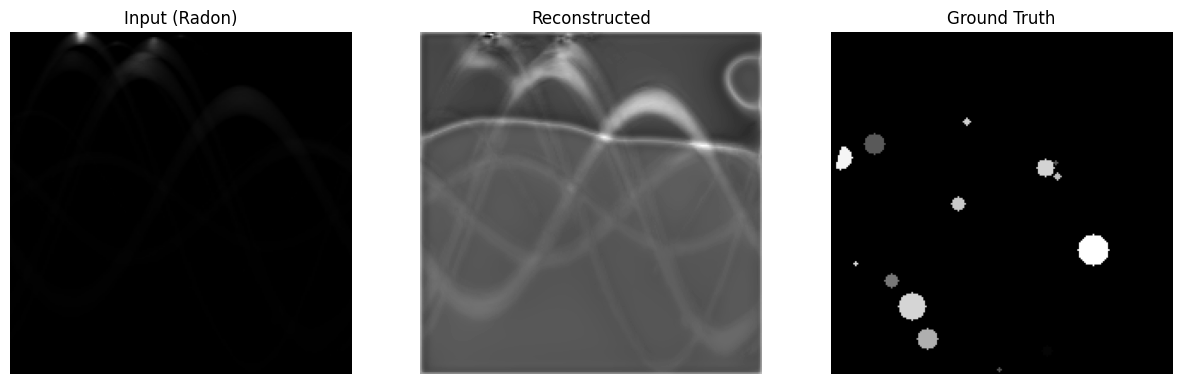

Epoch 2/2
Batch [100/175], Loss: 0.0348
Batch [175/175], Loss: 0.0307
Training Loss: 0.0382
Validation Loss: 0.0375


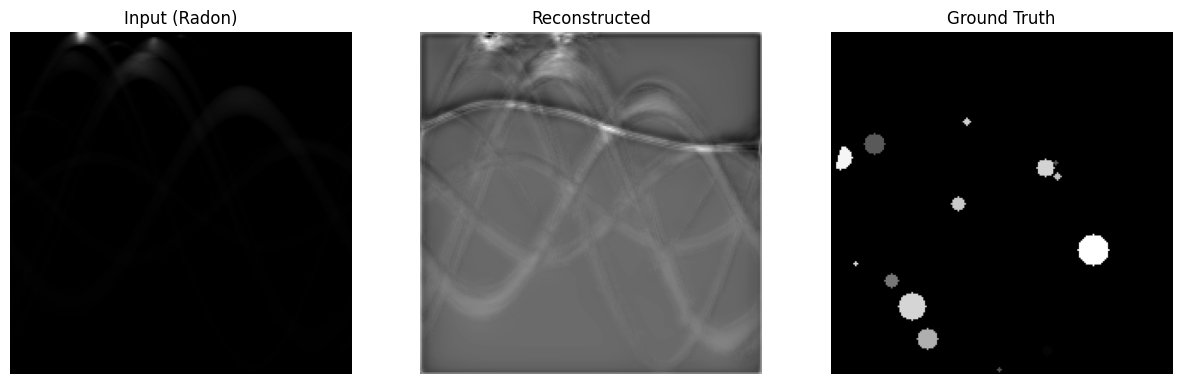

Training complete.


In [8]:
# Main Training Script
if __name__ == '__main__':
    # Set the device to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "mps")
    print(f'Using device: {device}')

    # Define a transformation to resize images to 200 by 200
    transform = transforms.Compose([
        transforms.Resize((200, 200)),
        transforms.ToTensor()
    ])

    # Paths for figure and sinogram images
    figure_path = os.path.expanduser('./mydata/figure')
    sinogram_path = os.path.expanduser('./mydata/sinogram')

    # Initialize dataset and split into training/validation
    sinogram_dataset = SinogramDataset(figure_path, sinogram_path, transform=transform)

    # Split the dataset into training, validation, and test sets (e.g., 70% train, 15% val, 15% test)
    train_size = int(0.7 * len(sinogram_dataset))
    val_size = int(0.15 * len(sinogram_dataset))
    test_size = len(sinogram_dataset) - train_size - val_size
    train_dataset, val_dataset, test_dataset = random_split(sinogram_dataset, [train_size, val_size, test_size])
    
    # Create data loaders for each split
    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

    # Initialize the U-Net model
    model = UNet(n_channels=1, n_classes=1).to(device)

    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    # Number of epochs to train
    num_epochs = 200

    # Training loop
    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')

        # Train the model for one epoch
        train_loss = train(model, train_loader, optimizer, criterion, device)
        print(f'Training Loss: {train_loss:.4f}')

        # Evaluate the model on the validation set
        val_loss = test(model, val_loader, criterion, device)
        print(f'Validation Loss: {val_loss:.4f}')

        # Plot results for the first batch of the validation set
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            plot_results(inputs, outputs, targets, idx=0)
            break  # Only plot the first batch

    print('Training complete.')


Visualizing test set results:


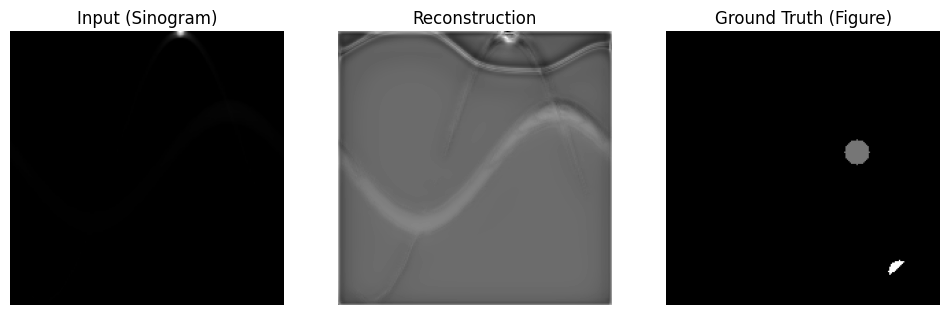

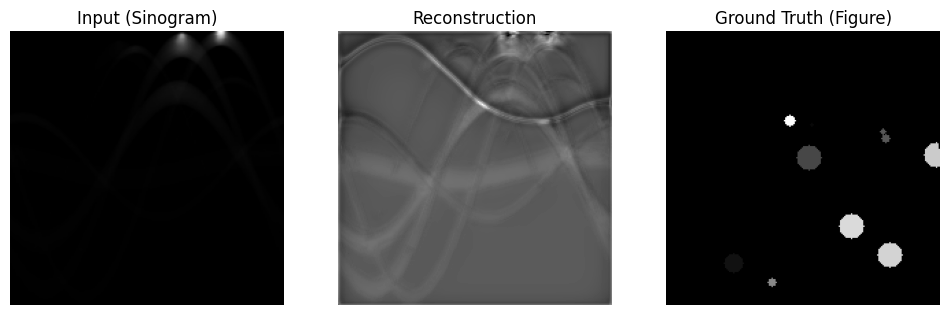

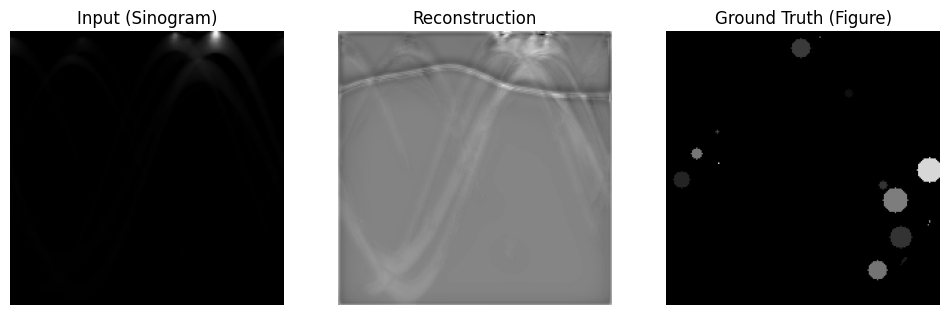

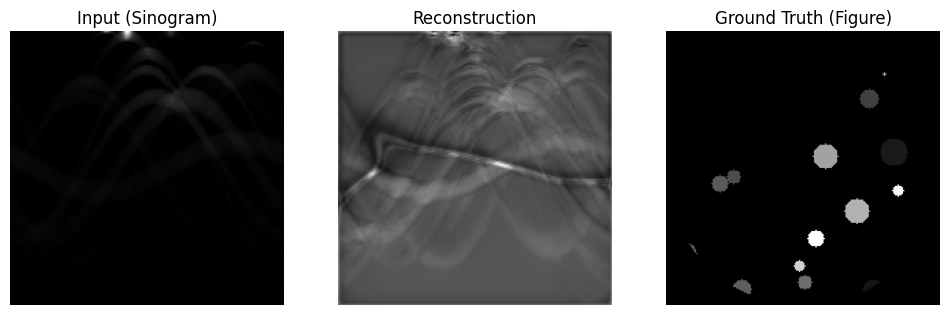

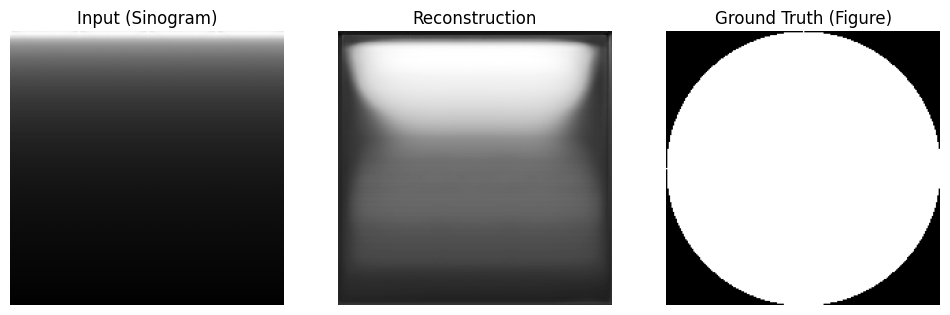

In [9]:
# Visualization function for results
def visualize_results(model, data_loader, device, num_samples=5):
    model.eval()  # Set the model to evaluation mode
    samples_shown = 0

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            for i in range(min(num_samples, inputs.size(0))):
                fig, ax = plt.subplots(1, 3, figsize=(12, 4))
                ax[0].imshow(inputs[i].cpu().squeeze(), cmap='gray')
                ax[0].set_title('Input (Sinogram)')
                ax[0].axis('off')

                ax[1].imshow(outputs[i].cpu().squeeze(), cmap='gray')
                ax[1].set_title('Reconstruction')
                ax[1].axis('off')

                ax[2].imshow(targets[i].cpu().squeeze(), cmap='gray')
                ax[2].set_title('Ground Truth (Figure)')
                ax[2].axis('off')

                plt.show()
                samples_shown += 1
                if samples_shown >= num_samples:
                    return  # Show only the specified number of samples

# After training, visualize results from the test set
print('Visualizing test set results:')
visualize_results(model, test_loader, device)

In [11]:
# test code for see shape of image
import os
from PIL import Image
import torch
from torchvision import transforms

# Define the path to your data
figure_path = os.path.expanduser('./mydata/figure')
sinogram_path = os.path.expanduser('./mydata/sinogram')

# Load one image to inspect
sample_idx = 0  # Use any index from 0 to 999, as you have 1000 images

# Load figure and sinogram images
figure_image = Image.open(os.path.join(figure_path, f'figure_{sample_idx + 1}.png'))
sinogram_image = Image.open(os.path.join(sinogram_path, f'sinogram_{sample_idx + 1}.png'))

# Convert to tensor if needed
transform = transforms.ToTensor()
figure_tensor = transform(figure_image)
sinogram_tensor = transform(sinogram_image)

# Print the size of the original images and tensors
print(f"Original figure image size: {figure_image.size}")
print(f"Original sinogram image size: {sinogram_image.size}")
print(f"Figure tensor shape: {figure_tensor.shape}")
print(f"Sinogram tensor shape: {sinogram_tensor.shape}")


Original figure image size: (200, 200)
Original sinogram image size: (180, 200)
Figure tensor shape: torch.Size([1, 200, 200])
Sinogram tensor shape: torch.Size([1, 200, 180])
